# Getting started with Scoot data

First things first: **Scoot data is a big dataset**.

> 100 days of SCOOT data from all sensors is approx 8GB.

Whilst your are testing and developing please reduce the amount of data you are requesting from the DB to reduce the strain on the DB. You can do this by restricting your queries:

- 1 day (or even one hour) of data if you are looking at spatial information
- aggregation of data if you want temporal trends. E.g. Take the sum of vehicle counts over all scoot sensors for each day.
- for spatial-temporal analysis, choose a subset of scoot detectors and perhaps also aggregate your data. E.g. 100 randomly chosen sensors (Coming soon: not yet implemented) for daily aggregates of data.

## Additional requirements for animations

To run and save the matplotlib animations you will need to install the following packages:

```bash
conda install ffmpeg
```

You may also need to re-run pip to install new requirements:

```bash
pip install -r containers/requirements.txt
```


In [1]:
%matplotlib notebook
import pandas as pd
import os
from datetime import datetime

# plotly viz - use matplotlib if you prefer
import plotly.graph_objects as go
import plotly.express as px

# cleanair modules
from cleanair.scoot import ScootQuery

# matplotlib and geospatial viz
import geopandas as gpd
from shapely import wkt
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
secretfile = "../../terraform/.secrets/db_secrets.json"

SQ = ScootQuery(secretfile=secretfile)

2020-03-24 14:51:03     INFO: Database connection information loaded from <_io.TextIOWrapper name='../../terraform/.secrets/db_secrets.json' mode='r' encoding='UTF-8'>


In [3]:
# get an aggregate of all the scoot data for the last 2 weeks
# agg_df = SQ.groupby_datetime_df(start_datetime="2020-03-10", end_datetime="2020-03-24")
agg_df = SQ.groupby_datetime_df(start_datetime="2020-02-01", end_datetime="2020-03-25")

In [4]:
agg_df.sample(10)

measurement_start_utc measurement_end_utc  sum_n_vehicles_in_interval  \
886    2020-03-12 01:00:00 2020-03-12 02:00:00                     1063457   
946    2020-03-14 14:00:00 2020-03-14 15:00:00                     4397919   
167    2020-02-11 02:00:00 2020-02-11 03:00:00                      729317   
134    2020-02-09 17:00:00 2020-02-09 18:00:00                     3836209   
477    2020-02-24 00:00:00 2020-02-24 01:00:00                     1390367   
1137   2020-03-22 14:00:00 2020-03-22 15:00:00                     3174752   
1091   2020-03-20 16:00:00 2020-03-20 17:00:00                     4270289   
248    2020-02-14 11:00:00 2020-02-14 12:00:00                     4223599   
591    2020-02-28 18:00:00 2020-02-28 19:00:00                     4589591   
1011   2020-03-17 08:00:00 2020-03-17 09:00:00                     4434159   

      avg_occupancy_percentage  avg_congestion_percentage  \
886                   3.088054                   0.641357   
946                  16.084334                   4.250406   
167                   2.247893                   0.534532   
134                  12.275614                   2.524083   
477                   3.781981                   0.532576   
1137                  8.592126                   1.213130   
1091                 14.941283                   3.619390   
248                  16.136416                   4.338583   
591                  19.213971                   6.100831   
1011                 18.413192                   5.754643   

      avg_saturation_percentage  sum_flow_raw_count  sum_occupancy_raw_count  \
886                   11.525141           366412199                336359318   
946                   53.690746           370053485                339874017   
167                    8.490537           365622410                336055085   
134                   42.686148           367678670                336335368   
477                   14.440375           360545479                328232999   
1137                  32.440310           368077305                336703580   
1091                  50.339001           371879885                342170211   
248                   53.584834           370405897                341745541   
591                   60.886285           372651341                344076377   
1011                  58.795639           377313001                349132753   

      sum_congestion_raw_count  sum_saturation_raw_count  
886                  318676629                 246876378  
946                  319523541                 316179427  
167                  318424140                 233009508  
134                  315257497                 306307374  
477                  311303767                 250568187  
1137                 315825449                 310116568  
1091                 323088568                 324949107  
248                  322740891                 320477810  
591                  324645867                 324588390  
1011                 328387167                 329282416

In [5]:
col = "sum_n_vehicles_in_interval"

fig = px.line(agg_df, x="measurement_start_utc", y=col)
fig.show()

In [6]:
# set the mapbox token
secrets_dir = "../../terraform/.secrets"
mapbox_filepath = os.path.join(secrets_dir, ".mapbox_token")
mapbox_access_token = open(mapbox_filepath).read()
px.set_mapbox_access_token(mapbox_access_token)

col = "n_vehicles_in_interval"
lower_bound = 500  # must have at least this many vehicles to appear on map
timestamp = "2020-03-11 12:00:00"

# query all scoot data for the given timestamp  
scoot_df = SQ.get_readings_for_hour(timestamp)


In [7]:
# DECREASE NUMBER OF ROWS IN DATAFRAME
# otherwise we will have problems rendering cause too many scoot sensors
filtered_df = scoot_df.loc[
    (scoot_df[col] > lower_bound) & (scoot_df["measurement_start_utc"] == timestamp)
]

# get the mapbox figure
map_dict = px.scatter_mapbox(
    filtered_df,
    lat="lat",
    lon="lon",
    size=[2 for i in range(len(filtered_df.index))],
    color=col,
    zoom=10,
    mapbox_style="basic",
)
map_fig = go.FigureWidget(map_dict)
map_fig.show()

In [8]:
start_datetime="2020-02-23 06:00:00"
end_datetime="2020-02-23 18:00:00"
df = SQ.groupby_sensor_df()

In [9]:
df.all()

st_astext                    True
name                         True
measurement_start_utc        True
n_vehicles_in_interval       True
avg_occupancy_percentage     True
avg_congestion_percentage    True
avg_saturation               True
dtype: bool

In [10]:
df['geom'] = df['st_astext'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geom')

In [11]:
time_range = pd.date_range(start_datetime, end_datetime, freq='H')

<IPython.core.display.Javascript object>


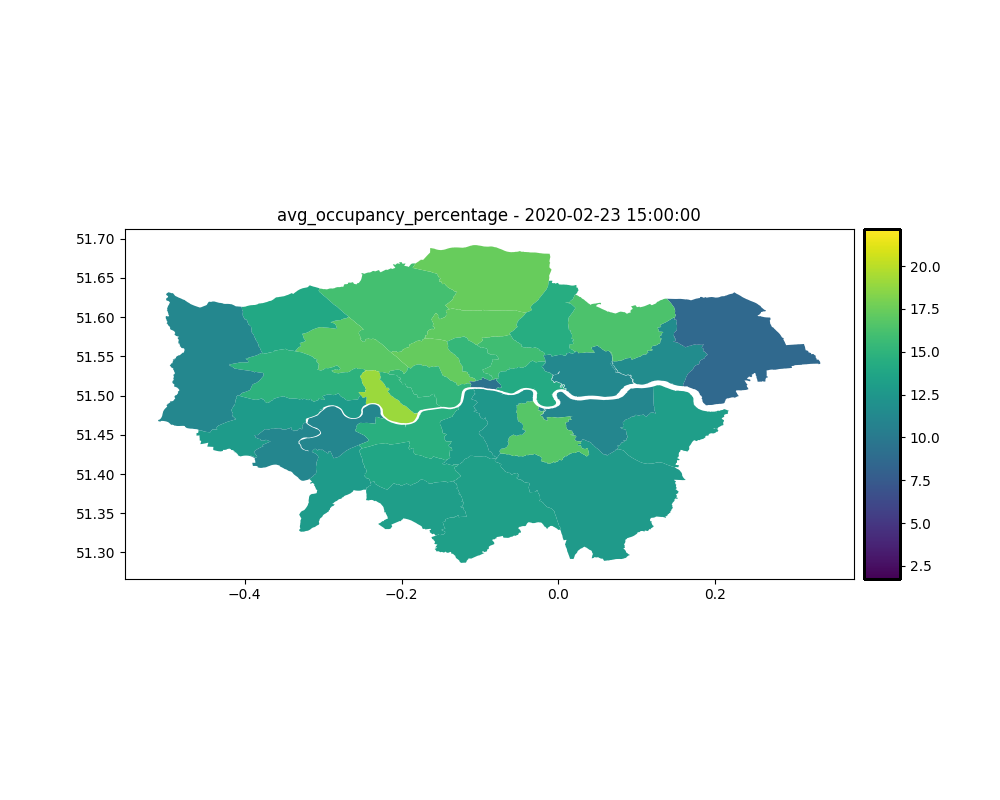

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
xdata, ydata = [], []

col = 'avg_occupancy_percentage'

norm = matplotlib.colors.Normalize(vmin=np.min(df[col]),vmax=np.max(df[col]))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

def init():
    ax.set_title(col+' - '+str(time_range[0]))
    df_tmp = df[df['measurement_start_utc']==time_range[0]]
    df_tmp.plot(column=col, figsize=(20, 10),ax=ax, norm=norm, legend=True, cax=cax)

def update(frame):
    ax.clear()
    ax.set_title(col+' - '+str(frame))
    df_tmp = df[df['measurement_start_utc']==frame]
    df_tmp.plot(column=col, figsize=(20, 10),ax=ax, norm=norm, legend=True, cax=cax)

ani = FuncAnimation(fig, update, frames=time_range, init_func=init)


In [13]:
# Set up formatting for the movie files
Writer = matplotlib.animation.FFMpegWriter
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

ani.save('im.mp4',  writer=writer)

2020-03-24 14:51:40     INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2020-03-24 14:51:40     INFO: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x800', '-pix_fmt', 'rgba', '-r', '10', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=Me', '-y', 'im.mp4']
/Users/pohara/opt/anaconda3/envs/cleanair/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.



In [14]:
from IPython.display import HTML
HTML(ani.to_jshtml())

2020-03-24 14:51:41     INFO: Animation.save using <class 'matplotlib.animation.HTMLWriter'>
/Users/pohara/opt/anaconda3/envs/cleanair/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

